# Regression Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [0]:
url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'

df = pd.read_csv(url)

#columns to drop bc of NaNs:
drop_cols = ['Alley', 'Fence', 'MiscFeature']
df = df.drop(columns = drop_cols)

#Fill Nans for garage yr blt w/ YearBlt value:
nums = df[df.GarageYrBlt.isna() == True].index
for i in nums:
  df.at[i, 'GarageYrBlt'] = df.at[i, 'YearBuilt']
  
#drop 8 rows of masonry veneer area Nans:
df.dropna(subset=['MasVnrArea'], inplace=True)

#replace most of the categoricals with numbers:
map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.NaN: 0}
df = df.replace(map)

#Fill NaNs for LotFrontage as 0:
#df['LotFrontage'] = df['LotFrontage'].fillna(0)

#create log price column
df['ln_price'] = np.log(df['SalePrice'])

#age:
df['age'] = 2010 - df['YearBuilt']

#renovation_age:
df['renovation_age'] = 2010 - df['YearRemodAdd']

#yard size (ignores deck, pool, etc):
df['yard_size'] = df['LotArea'] - df['1stFlrSF']

#garage finish:
finish_map = {'Fin':3, 'RFn': 2, 'Unf':1, np.NaN:0}
df['GarageFinish'] = df['GarageFinish'].replace(finish_map)

#sale condition:
sale_map = {'Normal': 3,
            'Partial': 3,
            'Abnorml': 1,
            'Family': 1,
            'AdjLand': 2,	
            'Alloca': 2}

df['SaleCondition'] = df['SaleCondition'].replace(sale_map)

#Lot shape:
shape_map = {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1}
df["LotShape"] = df["LotShape"].replace(shape_map)

#Street:
street_map = {'Grvl':1, 'Pave':2}
df['Street'] = df['Street'].replace(street_map)

#Neighborhood Quality:
neighborhood_qual_map = dict(df.groupby('Neighborhood', as_index=False)['OverallQual'].mean().set_index('Neighborhood')['OverallQual'])
df['neighborhood_qual']= df['Neighborhood'].map(neighborhood_qual_map)

#Neighborhood avg Sales price:
neighborhood_sales_map = dict(df.groupby('Neighborhood', as_index=False)['SalePrice'].mean().set_index('Neighborhood')['SalePrice'])
df['neighborhood_avg_sale_price'] = df['Neighborhood'].map(neighborhood_sales_map)

#Neighborhood avg log_Sales price:
neighborhood_ln_sales_map = dict(df.groupby('Neighborhood', as_index=False)['ln_price'].mean().set_index('Neighborhood')['ln_price'])
df['neighborhood_avg_ln_sale_price'] = df['Neighborhood'].map(neighborhood_ln_sales_map)


In [0]:
df = df.select_dtypes(include='number')

## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

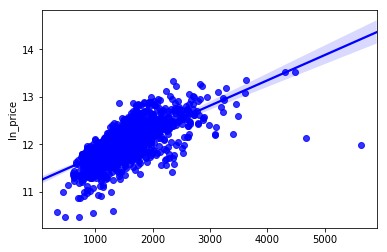

In [4]:
x_vals = df.GrLivArea.values
y_vals = df.ln_price

sns.regplot(x_vals, y_vals, color='blue')
plt.show()

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [0]:
#paste linear regression function from prev assignments:

def run_linear_model(X, y):
    # Split into test and train data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

    # Fit model using train data
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions using test features
    y_pred = model.predict(X_test)

    # Compare predictions to test target
    rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
    r2 = r2_score(y_test, y_pred)

    print('Root Mean Squared Error', rmse)
    print('R^2 Score', r2)
    print('Intercept', model.intercept_)
    coefficients = pd.Series(model.coef_, X_train.columns)
    print(coefficients.to_string())

In [0]:
#loop thru our numeric columns and keep ones that have an r2 over 0.3:

cols = df.drop(columns=['Id', 'ln_price', 'SalePrice', 'neighborhood_avg_sale_price']).columns

cols_to_use = []
  
for col in cols:
  X = df[[col]]
  y = df.SalePrice
  # Split into test and train data
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

  # Fit model using train data
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Make predictions using test features
  y_pred = model.predict(X_test)

  # Compare predictions to test target
  r2 = r2_score(y_test, y_pred)
  if r2 > 0.3:
    cols_to_use.append(col)
    

In [7]:
cols_to_use

['OverallQual',
 'ExterQual',
 'BsmtQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'KitchenQual',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'neighborhood_qual',
 'neighborhood_avg_ln_sale_price']

In [8]:
X = df[cols_to_use]
y = df.SalePrice

run_linear_model(X, y)

Root Mean Squared Error 30171.947770575935
R^2 Score 0.8509212319600052
Intercept -816484.7859355079
OverallQual                       10548.115638
ExterQual                          9782.877983
BsmtQual                           9276.547170
TotalBsmtSF                           0.378904
1stFlrSF                             22.632953
GrLivArea                            41.216643
FullBath                          -5549.656645
KitchenQual                       12085.155246
TotRmsAbvGrd                        524.985460
FireplaceQu                        1710.778048
GarageYrBlt                        -104.789975
GarageCars                         5229.563180
GarageArea                           21.189183
neighborhood_qual                 -5832.701959
neighborhood_avg_ln_sale_price    79963.616273


In [9]:
#repeat w/ statsmodels:

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     408.6
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        20:39:02   Log-Likelihood:                -17233.
No. Observations:                1452   AIC:                         3.450e+04
Df Residuals:                    1436   BIC:                         3.458e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

The low p-values (under 0.05) indicate we can reject the null hypothesis that the coefficient is equal to zero, or has no effect. P-values above 0.05 indicate that the predictor/feature is unlikely to be a meaningful addition to the model.

## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [10]:
df_no_outliers = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

X = df_no_outliers[cols_to_use]
y = df_no_outliers.SalePrice

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     380.5
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        20:39:03   Log-Likelihood:                -9906.1
No. Observations:                 867   AIC:                         1.984e+04
Df Residuals:                     851   BIC:                         1.992e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [11]:
X = df_no_outliers[cols_to_use]
y = df_no_outliers.ln_price

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     445.8
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        20:39:03   Log-Likelihood:                 681.00
No. Observations:                 867   AIC:                            -1330.
Df Residuals:                     851   BIC:                            -1254.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_const = sm.add_constant(X)
vif = [variance_inflation_factor(X_const.values, i) for i in range(len(X_const.columns))]
pd.Series(vif, X_const.columns)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const                             37158.793297
OverallQual                           3.681948
ExterQual                             3.039254
BsmtQual                              2.888090
TotalBsmtSF                           6.541809
1stFlrSF                              6.419228
GrLivArea                             4.735580
FullBath                              2.638887
KitchenQual                           2.462187
TotRmsAbvGrd                          3.240950
FireplaceQu                           1.405394
GarageYrBlt                           3.146841
GarageCars                            4.291972
GarageArea                            3.826460
neighborhood_qual                    16.132169
neighborhood_avg_ln_sale_price       13.439215
dtype: float64

In [13]:
cols_to_use[:-2]

['OverallQual',
 'ExterQual',
 'BsmtQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'KitchenQual',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

In [14]:
X = df_no_outliers[cols_to_use[:-2]]
y = df_no_outliers.ln_price

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     424.7
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        20:39:03   Log-Likelihood:                 607.27
No. Observations:                 867   AIC:                            -1187.
Df Residuals:                     853   BIC:                            -1120.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.6854      0.560     15.516   

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

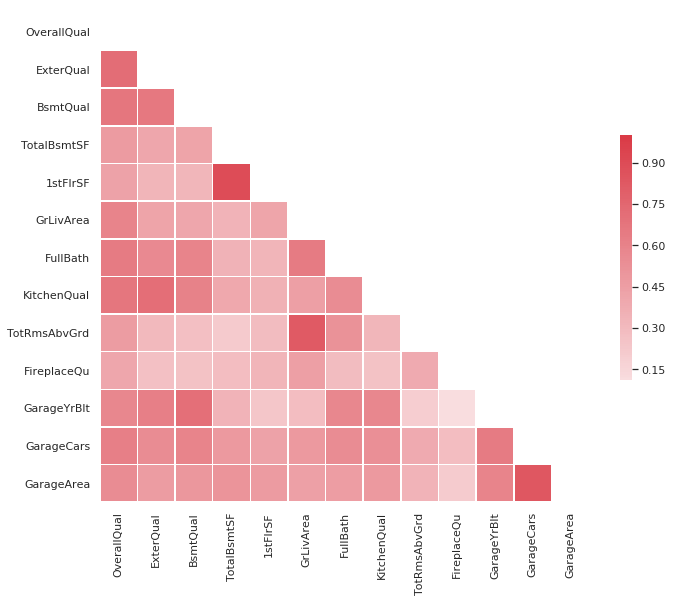

In [15]:
sns.set(style="white")

# Compute the correlation matrix
corr = df_no_outliers[cols_to_use[:-2]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 2.3 If you have variables with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In [23]:
#remove GarageCars, TotRmsAbvGrd, 1stFlrSF

cols = ['OverallQual',
 'ExterQual',
 'BsmtQual',
 'TotalBsmtSF',
 'GrLivArea',
 'FullBath',
 'KitchenQual',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageArea']

#Regression:

X = df_no_outliers[cols]
y = df_no_outliers.ln_price

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     550.7
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        20:40:07   Log-Likelihood:                 604.97
No. Observations:                 867   AIC:                            -1188.
Df Residuals:                     856   BIC:                            -1136.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.6258      0.553     15.592      

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [24]:
#VIF test:
X_const = sm.add_constant(X)
vif = [variance_inflation_factor(X_const.values, i) for i in range(len(X_const.columns))]
pd.Series(vif, X_const.columns)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const          18063.737185
OverallQual        3.425586
ExterQual          2.894510
BsmtQual           2.733605
TotalBsmtSF        1.528931
GrLivArea          2.325428
FullBath           2.542504
KitchenQual        2.444623
FireplaceQu        1.354441
GarageYrBlt        2.993319
GarageArea         2.072527
dtype: float64

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [25]:
X = df_no_outliers[cols]
y = df_no_outliers.ln_price

model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     505.0
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        20:40:14   Log-Likelihood:                 604.97
No. Observations:                 867   AIC:                            -1188.
Df Residuals:                     856   BIC:                            -1136.
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.6258      0.695     12.408      

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

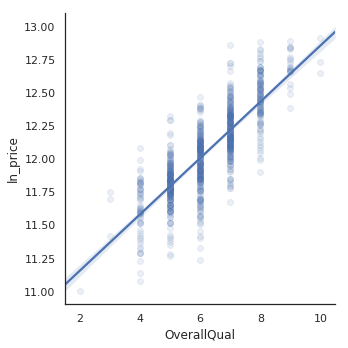

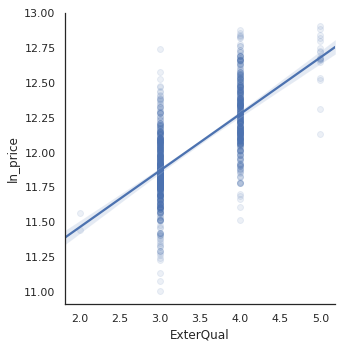

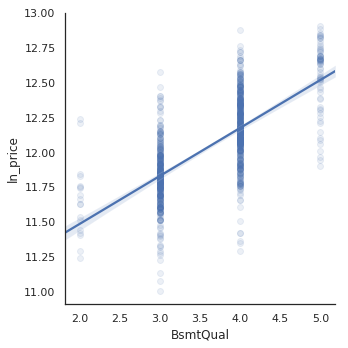

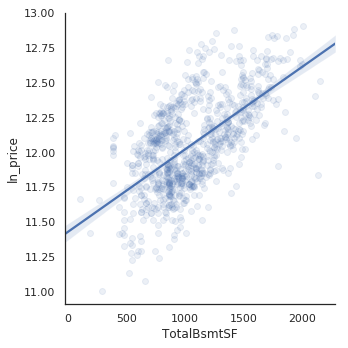

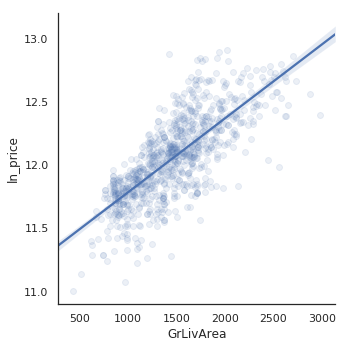

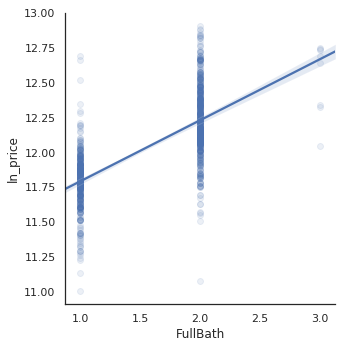

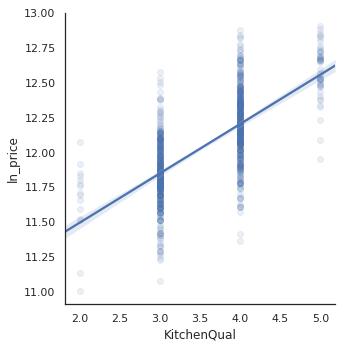

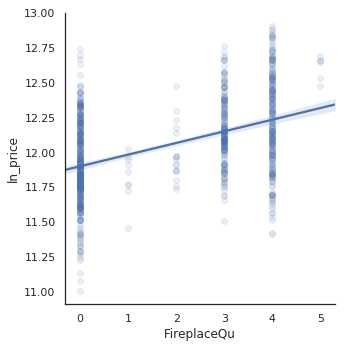

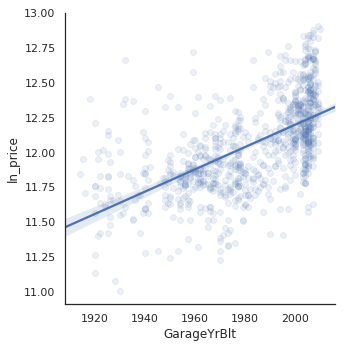

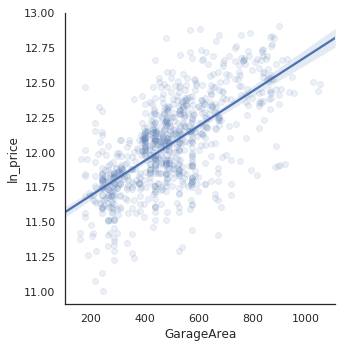

In [26]:
target = 'ln_price'
features = cols
for feature in features:
    sns.lmplot(x=feature, y=target, data=df_no_outliers, scatter_kws=dict(alpha=0.1))
    plt.show()

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

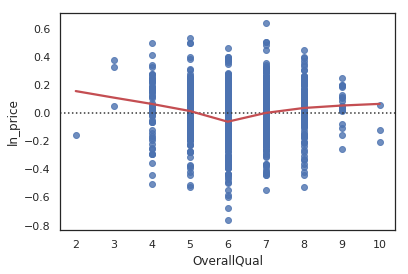

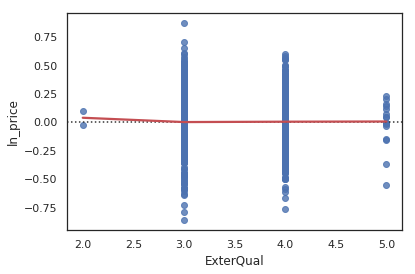

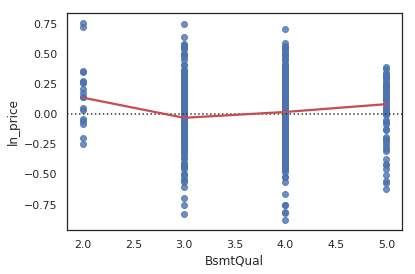

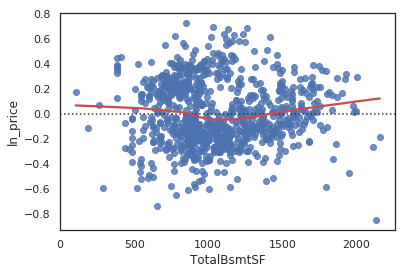

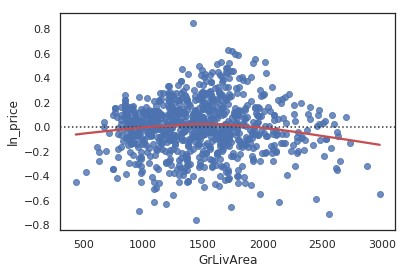

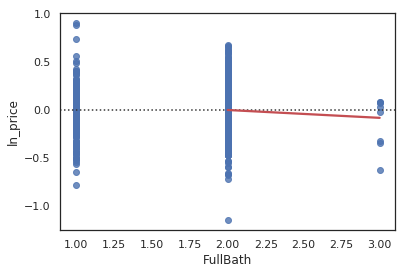

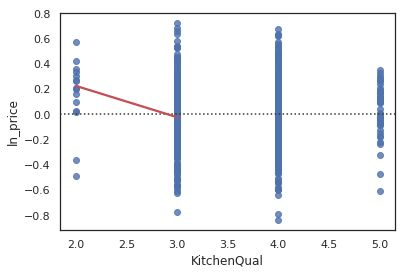

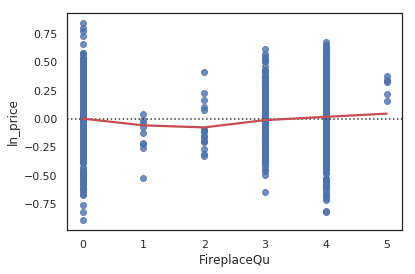

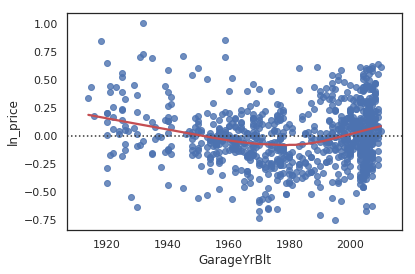

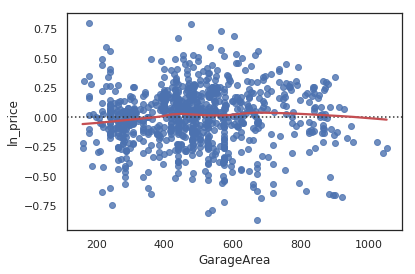

In [27]:
for feature in features:
    sns.residplot(X[feature], y, lowess=True, line_kws=dict(color='r'))
    plt.show()

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [20]:
df_no_outliers['GarageYrBlt_squared'] = df_no_outliers['GarageYrBlt']**2
df_no_outliers['TotalBsmtSF_squared'] = df_no_outliers['TotalBsmtSF']**2
df_no_outliers['GrLivArea_squared'] = df_no_outliers['GrLivArea']**2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [0]:
cols.append('GarageYrBlt_squared')
cols.append('TotalBsmtSF_squared')
cols.append('GrLivArea_squared')

In [22]:
X = df_no_outliers[cols]
y = df_no_outliers.ln_price

model = sm.OLS(y, sm.add_constant(X))
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_price   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     402.4
Date:                Wed, 01 May 2019   Prob (F-statistic):               0.00
Time:                        20:39:12   Log-Likelihood:                 616.84
No. Observations:                 867   AIC:                            -1206.
Df Residuals:                     853   BIC:                            -1139.
Df Model:                          13                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -15.5742    

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Stretch Goals

- Research the assumptions that are required for OLS to be BLUE the "Best Linear Unbiased Estimator". You might try searching and trying to understand the conditions of what's called the Gauss-Markov Theorem.
- Research other diagnostic tests. Can you show that residuals are normally distributed graphically?
- Write a blog post about inferential modeling using linear regression.